# Time Series Analysis for Physics

### Daniel Wrench
### ML4HEP 2025 Pre-School

1. Fix forecasts
2. Tidy rest of notebook
3. See my previous notes on GPs
2. Compare with white noise, turbulent power spectrum.

- *See here for customization options: https://rise.readthedocs.io/en/latest/customize.html#how-to-customize*
- *Grav waves work: https://scholar.google.com/citations?view_op=list_works&hl=en&hl=en&user=N0qz4VkAAAAJ*
- Seaborn: https://seaborn.pydata.org/tutorial/relational.html#emphasizing-continuity-with-line-plots 
- Astropy: https://docs.astropy.org/en/stable/timeseries/index.html 
- SKlearn examples: https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html#sphx-glr-auto-examples-applications-plot-cyclical-feature-engineering-py 

## Outline

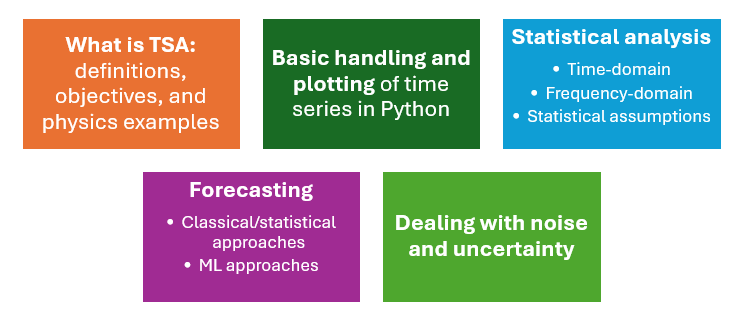

## What is a time series?

- Series of points, indexed by time
- A realisation of a *stochastic process*, e.g.
    - White noise
    - Brownian motion
- Could be *signals*, e.g. voltage, current, EM wave
- Very likely **autocorrelated**
- Might or might not be **periodic**, **stationary**... **predictable?**

Stochastic process = theoretical mathematical object: the value at each time step is a random variable with a probability distribution. Each of these figs is one realisation of that SP.
Used as mathematical models of time series

Autocorrelation violates key assumption of many statistical models.
For this reason TSA hares properties with the study of spatial data: many of the same statistics. Language too!
Once you have a model that describes some data, natural to wonder if it is a good enough fit to the data to allow you to make predictions. For time series: this is the art of forecasting. 

## Time series analyses in physics

- Extracting dominant frequencies in the light curves of pulsars
- Detecting gravitational waves
- Analyzing turbulence in the magnetic field of the solar wind
- Predicting space weather

## Read and plot data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
import warnings
warnings.filterwarnings('ignore')

plt.rcParams.update({'font.size': 16})
# Increase default figure size
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
df = pd.read_csv("SN_m_tot_V2.0.csv", header=None, delimiter=';',names=[
        "year",
        "month",
        "decimal_date",
        "SN",
        "SN_std",
        "nb_obs",
        "provisional",
    ])

df["day"] = "1" # For creating a timestamp
df["SN"] = df["SN"].replace(-1, np.nan)  # Replace -1 with NaN
df["Timestamp"] = pd.to_datetime(df[["year", "month", "day"]])

ts = df[["Timestamp", "SN"]].set_index("Timestamp")
ts = ts["1973":]

In [3]:
ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 628 entries, 1973-01-01 to 2025-04-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SN      628 non-null    float64
dtypes: float64(1)
memory usage: 9.8 KB


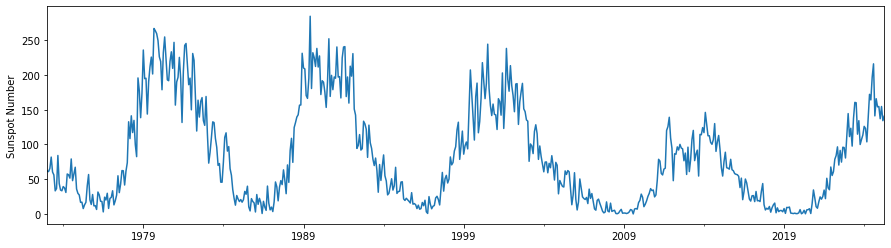

In [4]:
ts.plot(ylabel="Sunspot Number", legend=False, xlabel="", figsize=(15, 4));
#plt.plot(ts) # No need to specify x and y

Let's make an interactive one

In [2]:
import plotly.express as px

In [3]:
fig = px.line(ts, x=ts.index, y="SN", height=400, width=800)
fig.show()

NameError: name 'ts' is not defined

Often looking to decompose into three parts: 

1. Trend
2. Seasonality/periodicity
3. Noise

Do we notice any of those here?

### Smoothing a time series: 2 ways

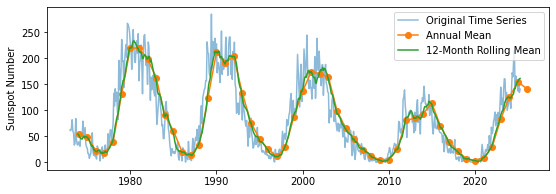

In [7]:
ts_smoothed = ts.rolling(window=12).mean()
ts_downsampled = ts.resample('YE').mean()

plt.figure(figsize=(9, 3))
plt.plot(ts, label="Original Time Series", alpha=0.5)
plt.plot(ts_downsampled, label="Annual Mean", marker='o')
plt.plot(ts_smoothed, label="12-Month Rolling Mean")
plt.ylabel("Sunspot Number")
plt.legend()

## Statistical description

- ACF
- PSD
- Stationarity and ergodicity

### Autocorrelation function

- Quantifies the *memory* of a time series: to what degree do previous values inform future values?

$$R(\tau)=\frac{\langle x(t)x(t+\tau)\rangle}{\text{Var}(x)}$$

- Note denominator: assumes weak stationarity

In [8]:
from statsmodels.tsa import stattools as tsa_funcs

### ACF of white noise

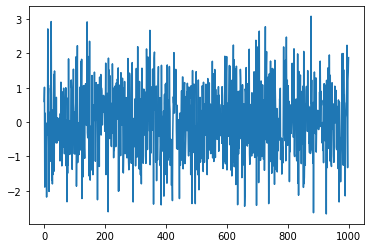

In [27]:
white_noise = np.random.randn(1000)
plt.plot(white_noise)

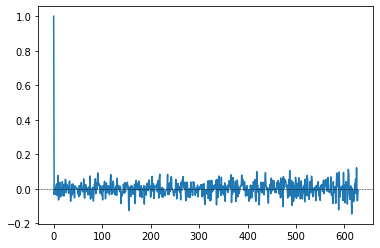

In [28]:
acf = tsa_funcs.acf(white_noise, nlags=len(ts), adjusted=True)
plt.plot(acf)
plt.axhline(0, color="black", lw=0.5, ls="--")

ACF of sunspots

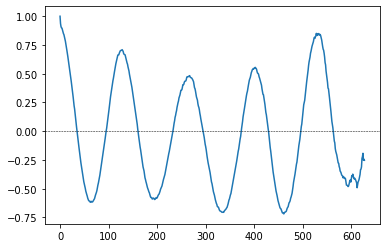

In [29]:
acf = tsa_funcs.acf(ts, nlags=len(ts), adjusted=True)
plt.plot(acf)
plt.axhline(0, color='black', lw=0.5, ls='--')


Text(0.5, 1.0, '$\\frac{1}{1 - 2 \\cos(\\omega) + 0.5 \\cos(2\\omega)}$')

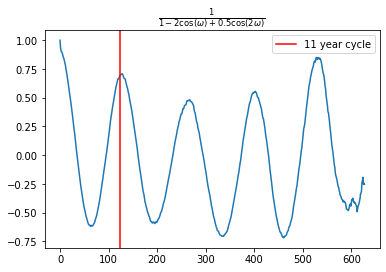

In [ ]:
plt.plot(acf)
# Add vertical lines at lags corresponding to 11 years
plt.axvline(12*10.3, color='red', label = "11 year cycle")
plt.legend()

### Power spectrum
- Revealing the distribution of power/energy at different scales/frequencies in the signal.
- Squared magnitude of Fourier transform: removes phase information for simpler analysis.
- Requires corrections for aliasing, leakage

$$E(f) = \left| \int_{-\infty}^{\infty} x(t) e^{-2\pi i f t} dt \right|^2$$

$$=\int_{-\infty}^{\infty} R(\tau) e^{-i2\pi f\tau} d\tau$$


As we know from Fourier in 1822, "any signal can be decomposed into a sum of periodic components". 
Computed using efficient FFT. However, requires evenly-spaced data. If not, could use Lomb-Scargle periodogram. 

Run into issues from time to freq domain around edge effects, leakage. Requires things like windowing, pre-whitening, post-darkening.

PSD of white noise

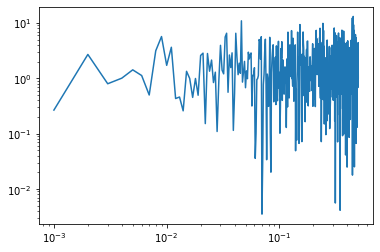

In [31]:
fs = 1
f, Pxx_den = signal.periodogram(x=white_noise, fs=fs)
plt.loglog(f[1:], Pxx_den[1:])

PSD of sunspots

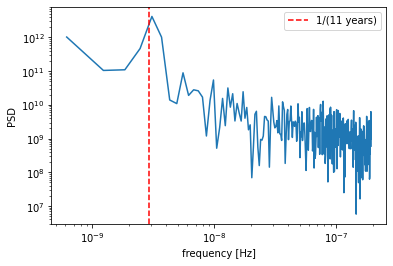

In [11]:
s_in_month = (60*60*24*30)
fs = 1/s_in_month
f, Pxx_den = signal.periodogram(x=ts.SN, fs=fs) 
plt.loglog(f[1:], Pxx_den[1:])
plt.axvline(1/(s_in_month*12*11), color='red', linestyle='--', label='1/(11 years)')
plt.legend()
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD')
plt.show()

In [12]:
peak_f = f[Pxx_den==Pxx_den.max()]
peak_period_s = 1/peak_f
peak_period_years = peak_period_s / (60*60*24*365)
peak_period_years

array([10.32328767])

### Removing seasonal patterns

- Allows us to detect underlying trends and detect outliers/anomalies
- Prepares the data for forecasting models like ARIMA by improving stationarity

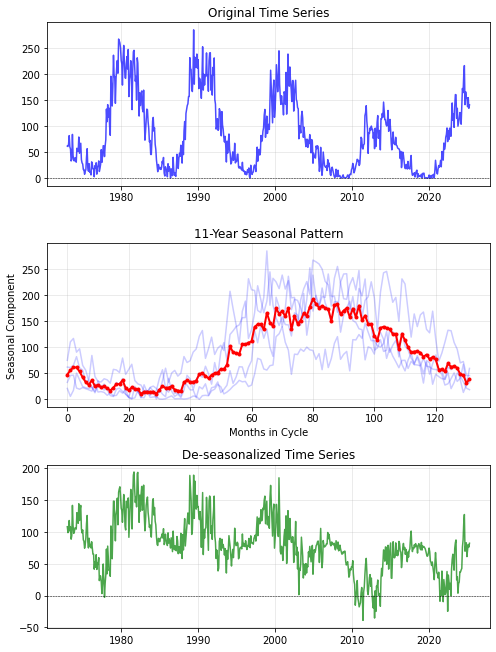

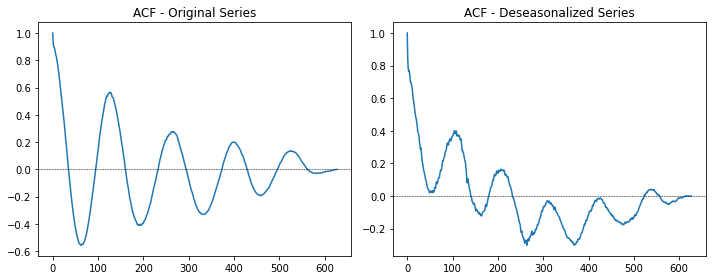

Seasonal pattern statistics:
Mean seasonal amplitude: 88.1773
Max seasonal amplitude: 191.9750
Seasonal pattern variance: 3279.0361


In [13]:
# Method 1: Simple seasonal decomposition (assuming exactly 100-point cycle)
seasonal_period = int(12*11)

# Calculate seasonal component by averaging over all cycles
ts_clean = ts["SN"]
n_full_cycles = len(ts_clean) // seasonal_period
ts_truncated = ts_clean[:n_full_cycles * seasonal_period]

# Reshape to separate cycles and compute mean seasonal pattern
ts_reshaped = ts_truncated.values.reshape(-1, seasonal_period)
seasonal_pattern = np.mean(ts_reshaped, axis=0)

# Extend seasonal pattern to match original series length
n_repeats = len(ts_clean) // seasonal_period + 1
seasonal_extended = np.tile(seasonal_pattern, n_repeats)[:len(ts_clean)]

# Remove seasonal component
ts_deseasonalized = ts_clean - seasonal_extended

# Method 2: Using moving average for more robust seasonal removal
# Calculate centered moving average with period = seasonal_period
ts_trend = ts_clean.rolling(window=seasonal_period, center=True).mean()
ts_detrended = ts_clean - ts_trend

# Calculate seasonal indices
seasonal_indices = []
for i in range(seasonal_period):
    season_values = []
    for j in range(i, len(ts_detrended), seasonal_period):
        if not pd.isna(ts_detrended.iloc[j]):
            season_values.append(ts_detrended.iloc[j])
    seasonal_indices.append(np.mean(season_values) if season_values else 0)

# Create full seasonal component
seasonal_component = []
for i in range(len(ts_clean)):
    seasonal_component.append(seasonal_indices[i % seasonal_period])

ts_deseasonalized_v2 = ts_clean - seasonal_component

# Plot comparison of methods
plt.figure(figsize=(7, 12))

# Original series
plt.subplot(4, 1, 1)
plt.plot(ts_clean.index, ts_clean.values, 'b-', alpha=0.7)
plt.title('Original Time Series')
plt.axhline(0, color='black', lw=0.5, ls='--')

plt.grid(True, alpha=0.3)

# Seasonal pattern
plt.subplot(4, 1, 2)

for i in range(ts_reshaped.shape[0]):
    plt.plot(ts_reshaped[i], alpha=0.2, color='blue')
plt.plot(range(seasonal_period), seasonal_pattern, 'r-', linewidth=2, marker='o', markersize=3)
plt.title('11-Year Seasonal Pattern')
plt.xlabel('Months in Cycle')
plt.ylabel('Seasonal Component')
plt.grid(True, alpha=0.3)

# Deseasonalized series (Method 1)
plt.subplot(4, 1, 3)
plt.plot(ts_deseasonalized_v2.index, ts_deseasonalized_v2.values, 'g-', alpha=0.7)
plt.title('De-seasonalized Time Series')
plt.axhline(0, color='black', lw=0.5, ls='--')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Choose which deseasonalized series to use for subsequent analyses
# ts = ts_deseasonalized  # or ts_deseasonalized_v2

# Verify seasonal removal with autocorrelation
fig, ax = plt.subplots(1,2,figsize=(10, 4))

acf_clean = tsa_funcs.acf(ts_clean, nlags=len(ts))
ax[0].plot(acf_clean)
ax[0].axhline(0, color='black', lw=0.5, ls='--')
ax[0].set_title("ACF - Original Series")

acf_deseason = tsa_funcs.acf(ts_deseasonalized_v2, nlags=len(ts))
ax[1].plot(acf_deseason)
ax[1].axhline(0, color="black", lw=0.5, ls="--")
ax[1].set_title("ACF - Deseasonalized Series")

plt.tight_layout()
plt.show()

print(f"Seasonal pattern statistics:")
print(f"Mean seasonal amplitude: {np.mean(np.abs(seasonal_pattern)):.4f}")
print(f"Max seasonal amplitude: {np.max(np.abs(seasonal_pattern)):.4f}")
print(f"Seasonal pattern variance: {np.var(seasonal_pattern):.4f}")

## Assumption #1: Stationarity
- Key assumption for statistical description *AND* forecasting
- Number of statistical tests to check for it
- Can often be achieved by simply differencing the series, or otherwise de-trending, wavelet analysis

![](lecture_figs/non-stationary.png)

*Image from [Wellntel](https://wellntel.com/nonstationarity-the-importance-of-hydrologic-observations-and-data-to-water-management/)*

<Axes: xlabel='Timestamp'>

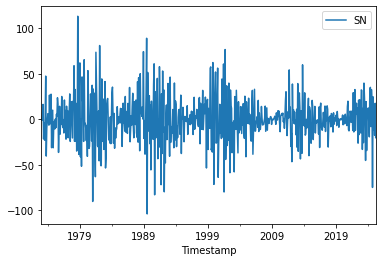

In [14]:
ts.diff(1).plot()

## Assumption #2: Ergodicity

![](lecture_figs/ergodicity.png)

- For an ergodic process, time average = ensemble average
- In other words, 

*Diagram from [Manu H](https://medium.com/@mhegdekatte/a-simple-explanation-of-ergodicity-in-finance-part-i-7b6892433645)*

Random walk example of a non-ergodic process: expectation is 0, but mean is a random variable.

## Forecasting

- Can equally be applied to interpolation! 
- Will always fail for anomalous events (think forecasts of tourism forecasts for 2020)
- Best to compare against simple persistence model: $x(t)=x(t-1)$
- ML models very popular (especially for language), but don't always produce confidence intervals)

In [15]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [16]:
# Prepare data for forecast models
scaler = MinMaxScaler()
ts_scaled = scaler.fit_transform(ts.dropna().values.reshape(-1, 1))

# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

seq_length = 60  # Adjust sequence length
X, y = create_sequences(ts_scaled, seq_length)

# Split data
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


### ARIMA forecast models

- Simple and fast to train
- Good for small, linear datasets and short forecasts, but quickly reverts to the mean.
- Use as baseline model for more cutting-edge methods

$$\begin{align*}
\text{ARIMA}(p, d, q) & : \text{Autoregressive Integrated Moving Average model} \\
\text{where } p & : \text{order of the autoregressive part} \\  
d & : \text{degree of differencing} \\
q & : \text{order of the moving average part} \\
\text{The model can be expressed as:} \\
Y_t & = c + \phi_1 Y_{t-1} + \phi_2 Y_{t-2} + \ldots + \phi_p Y_{t-p} \\
& \quad + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + \ldots + \theta_q \epsilon_{t-q} + \epsilon_t 
\end{align*}$$

In [17]:
from statsmodels.tsa.arima.model import ARIMA

# Unscaled series for ARIMA
ts_values = ts.dropna().values

# Align ARIMA training set with LSTM's by using same cutoff index (seq_length + train_size)
split_point = seq_length + train_size
arima_train, arima_test = ts_values[:split_point], ts_values[split_point:]

# Fit ARIMA on training data
arima_model = ARIMA(arima_train, order=(2,1,2))
arima_result = arima_model.fit()

# Forecast same number of steps as test set
arima_pred = arima_result.forecast(steps=len(y_test)).reshape(-1, 1)
arima_pred_original = arima_pred  # Already in original scale


### Recurrent neural networks
- Class of neural networks designed for sequential data
- *Recurrent connections*: Output of a neuron at one time step is fed back as input to the network and the next time step
- Problem of *vanishing gradients* is handled by Long Short-Term Memory (LSTM) modification.

![alt text](lecture_figs/1024px-Recurrent_neural_network_unfold.svg.png)

In [18]:
# Build LSTM model
model_lstm = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    LSTM(50),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse')

# Train LSTM
model_lstm.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

# Forecast with LSTM
lstm_pred = model_lstm.predict(X_test)
lstm_pred_original = scaler.inverse_transform(lstm_pred)
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))





4/4 [==============================] - 1s 17ms/step


### Gaussian process regression

- Great way of modeling uncertainty, and extrapolating *or* interpolating!
- Uses a model for the autocorrelation via a covariance matrix or *kernel*

- [Visual exploration](https://distill.pub/2019/visual-exploration-gaussian-processes/)
- [SK learn demo](https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_co2.html#sphx-glr-auto-examples-gaussian-process-plot-gpr-co2-py)



In [19]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# Flatten sequence input for GPR (LSTM uses 3D, GPR expects 2D)
X_train_gpr = X_train.reshape((X_train.shape[0], X_train.shape[1]))
X_test_gpr = X_test.reshape((X_test.shape[0], X_test.shape[1]))

# Define kernel and train GPR
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0)
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, normalize_y=True)

gpr.fit(X_train_gpr, y_train)
gpr_pred = gpr.predict(X_test_gpr).reshape(-1, 1)
gpr_pred_original = scaler.inverse_transform(gpr_pred)

# Get confidence intervals
gpr_pred_mean, gpr_pred_std = gpr.predict(X_test_gpr, return_std=True)
gpr_pred_mean_original = scaler.inverse_transform(gpr_pred_mean.reshape(-1, 1))
gpr_pred_std_original = scaler.inverse_transform(gpr_pred_std.reshape(-1, 1))

In [20]:
# from prophet import Prophet
# # Prepare data for Prophet (needs 'ds' and 'y' columns)
# prophet_df = pd.DataFrame({"ds": ts.index, "y": ts.values.ravel()})

# # Create Prophet model with custom seasonalities
# model = Prophet(
#     yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False
# )

# # Add the 11-year cycle as custom seasonality
# model.add_seasonality(name="eleven_year_cycle", period=365.25 * 11, fourier_order=5)

# # Fit the model
# model.fit(prophet_df)

# # Create future dataframe and forecast
# future = model.make_future_dataframe(periods=36, freq="M")
# forecast = model.predict(future)

# # Plot results
# model.plot(forecast)
# model.plot_components(forecast)

In [21]:
# plt.plot(ts)
# plt.plot(forecast["ds"], forecast["yhat"])
# plt.fill_between(
#     forecast["ds"],
#     forecast["yhat_lower"],
#     forecast["yhat_upper"],
#     color="gray",
#     alpha=0.2,
#     label="Uncertainty Interval",
# )

### Comparing model forecasts

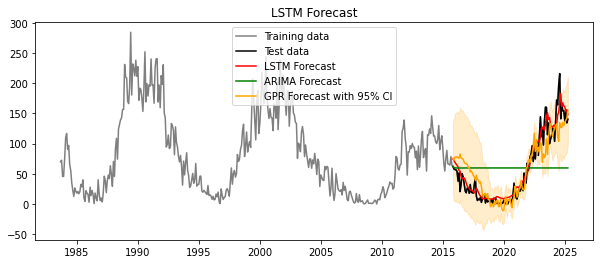

In [30]:
# Plot LSTM results
plt.figure(figsize=(10, 4))
test_index = ts.index[train_size+seq_length:]
plt.plot(ts[-500:], label='Training data', alpha=0.5, c="black")
plt.plot(test_index, y_test_original, label='Test data', color='black')
plt.plot(test_index, lstm_pred_original, label='LSTM Forecast', color='red')
plt.plot(test_index, arima_pred_original, label='ARIMA Forecast', color='green')
plt.plot(test_index, gpr_pred_original, label='GPR Forecast with 95% CI', color='orange')
plt.fill_between(
    ts.index[-len(y_test) :],
    gpr_pred_mean_original.flatten() - 1.96 * gpr_pred_std_original.flatten(),
    gpr_pred_mean_original.flatten() + 1.96 * gpr_pred_std_original.flatten(),
    color="orange",
    alpha=0.2,
)
plt.legend()
plt.title('LSTM Forecast')
plt.show()

## Deal with noise

Look at the effect of noise on the stats. *See app*.

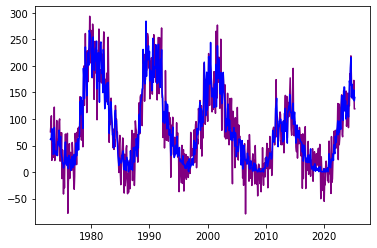

In [24]:
ts_with_noise = ts.SN + np.random.normal(0, 30, size=len(ts))
plt.plot(ts_with_noise, label='Time Series with Noise', color='purple')
plt.plot(ts, label='Original Time Series', color='blue')

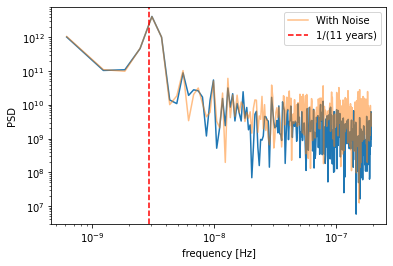

In [25]:

s_in_month = 60 * 60 * 24 * 30
fs = 1 / s_in_month
f, Pxx_den = signal.periodogram(x=ts.SN, fs=fs)
f, Pxx_den_noise = signal.periodogram(x=ts_with_noise, fs=fs)
plt.loglog(f[1:], Pxx_den[1:])
plt.loglog(f[1:], Pxx_den_noise[1:], label="With Noise", alpha=0.5)
plt.axvline(
    1 / (s_in_month * 12 * 11), color="red", linestyle="--", label="1/(11 years)"
)
plt.legend()
plt.xlabel("frequency [Hz]")
plt.ylabel("PSD")
plt.show()

## Solar wind example

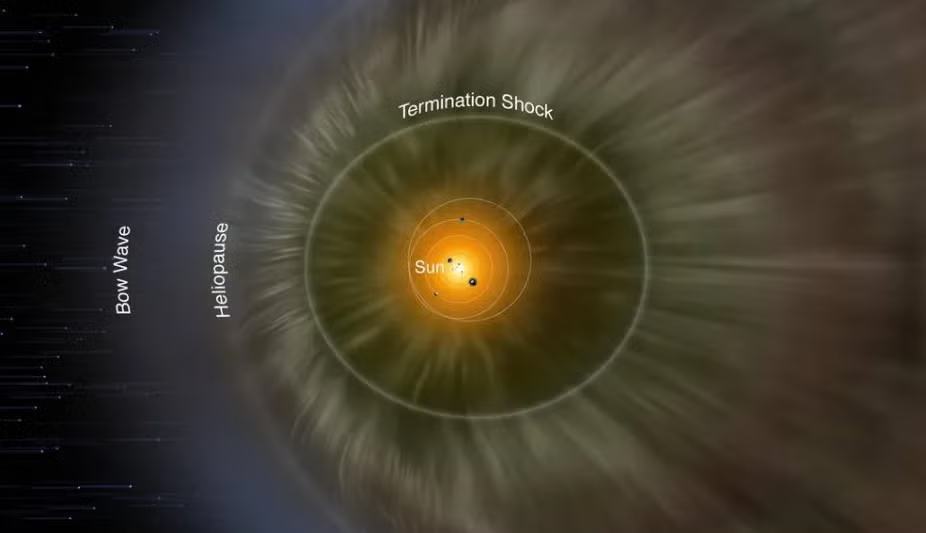

*image from https://scied.ucar.edu/learning-zone/sun-space-weather/solar-wind*

### Time series

Text(0.5, 1.0, 'PSP Magnetic Field Data')

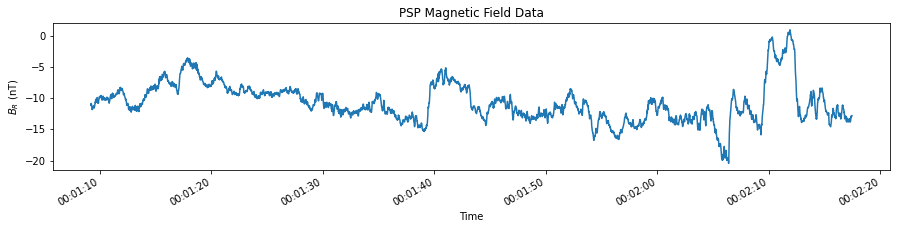

In [61]:
df = pd.read_pickle("data/processed/other stoff/psp_fld_l2_mag_rtn_201811.pkl")
psp = df.loc[:, "B_R"][:5000]
psp.plot(ylabel="$B_R$ (nT)", figsize=(15, 3), legend=False)
plt.title("PSP Magnetic Field Data")

### Solar wind ACF

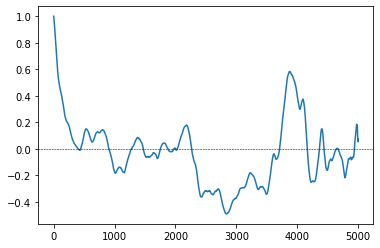

In [64]:
acf = tsa_funcs.acf(psp, nlags=len(psp), adjusted=True)
plt.plot(acf)
plt.axhline(0, color="black", lw=0.5, ls="--")

### Solar wind PSD

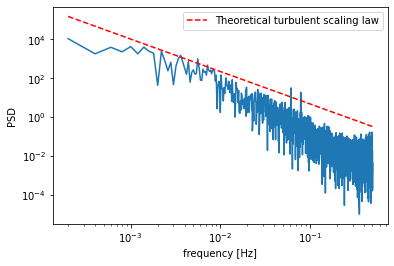

In [65]:
f, Pxx_den = signal.periodogram(x=psp, fs=1)
plt.loglog(f[1:], Pxx_den[1:])
# Add -5/3 slope line
x = np.log10(f[1:])
y = -5 / 3 * x
plt.plot(10**x, 10**y/10, color='red', linestyle='--', label='Theoretical turbulent scaling law')
plt.legend()
plt.xlabel("frequency [Hz]")
plt.ylabel("PSD")
plt.show()

What happens to the power spectrum if we add noise?

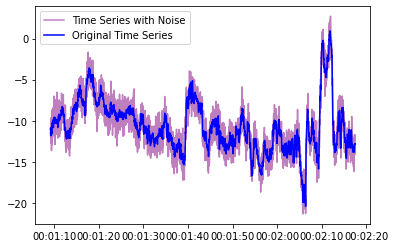

In [69]:
psp_with_noise = psp + np.random.normal(0, 1, size=len(psp))
plt.plot(psp_with_noise, label='Time Series with Noise', color='purple', alpha=0.5)
plt.plot(psp, label='Original Time Series', color='blue')
plt.legend()

Effect of noise on power spectrum

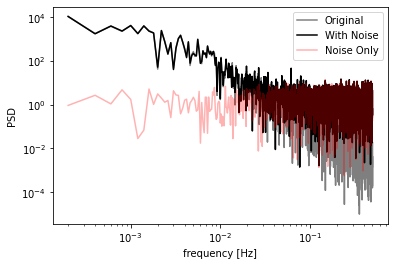

In [78]:
f, Pxx_den = signal.periodogram(x=psp, fs=1)
f, Pxx_den_noise = signal.periodogram(x=psp_with_noise, fs=1)
f, Pxx_den_noise_only = signal.periodogram(x=psp_with_noise - psp, fs=1)

plt.loglog(f[1:], Pxx_den[1:], label="Original", color='black', alpha=0.5)
plt.loglog(f[1:], Pxx_den_noise[1:], label="With Noise", color="black")
plt.loglog(f[1:], Pxx_den_noise_only[1:], label="Noise Only", color='red', alpha=0.3)

plt.legend()
plt.xlabel("frequency [Hz]")
plt.ylabel("PSD")
plt.show()

## Thoughts on machine learning and AI in physics

### ML models for physics data
- Do you just want accurate predictions - or do you want to understand something?
- Physics-informed machine learning

### LLMs
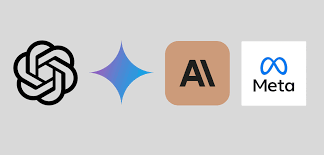
- **What do we gain?** Speeds up productivity immensely - assuming you are asking it the right questions and giving it the necessary context to understand your problem
- **What do we lose?**

# Time Series Analysis for Physics

### Daniel Wrench
### ML4HEP 2025 Pre-School